In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import defaultdict
import numpy as np
import pandas as pd
import unicodedata
#from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk.collocations as collocations
from nltk.util import ngrams
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, RocCurveDisplay, log_loss
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import datasets, layers, models, callbacks
from kerastuner.tuners import RandomSearch
from keras import backend as K
from imblearn.over_sampling import RandomOverSampler

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shock\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shock\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\shock\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shock\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shock\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import sklearn
sklearn.__version__

'0.23.2'

In [4]:
data = pd.read_csv("./raw_data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

In [5]:
# dopping null column from tweet_text column since it's only one and has no information for our analysis
data.tweet_text.isna().sum()
data.dropna(subset=['tweet_text'], inplace=True)

In [6]:
# looking at our .describe, there seems to be some duplicates in our data and we'll go ahead and keep unique inputs only
data.drop_duplicates(subset=['tweet_text'], inplace=True)

In [7]:
# Creating a cleaned emotion_in tweet_is_directed_at column
data.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [8]:
keywords = ["Apple", "Google", "iPad", "iPhone", "Android", "goog"]

for keyword in keywords:
    data[keyword] = data['tweet_text'].str.extract(f'({keyword})', flags=re.IGNORECASE)

data['product'] = data[['Apple', 'iPhone', 'iPad', 'Google', 'Android']].apply(lambda x: 'Apple' if x[['Apple', 'iPhone', 'iPad']].any() 
                                                                                else 'Google' if x[['Google', 'Android']].any() 
                                                                                else None, axis=1)

In [9]:
data['product'].value_counts()

Apple     5517
Google    2764
Name: product, dtype: int64

In [10]:
# Since we've classified our product column, we'll drop nulls as we're interested with apple and google products
data['product'].isna().sum()

784

In [11]:
#Dropped to focus on tweets where google and apple where mentioned
data.dropna(subset=['product'], inplace=True)

In [12]:
data['sentiment'].replace("I can't tell" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [13]:
target_to_replace = {'Positive emotion':2, 'Neutral emotion':1,
                   'Negative emotion':0}

data['sentiment']  = data['sentiment'].replace(target_to_replace)

In [14]:
data['sentiment'].value_counts(normalize=True)

1    0.577587
2    0.353822
0    0.068591
Name: sentiment, dtype: float64

In [15]:
data['product'].value_counts()

Apple     5517
Google    2764
Name: product, dtype: int64

In [16]:
data['product'] = data['product'].astype(str)

In [17]:
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm","rt" "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])

In [18]:
# Custom tokenizer
def doc_preparer(doc, stop_words=sw):

    #lemmatized, parsed for stopwords, made lowercase,and stripped of punctuation and numbers.
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    # Remove mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 2]  # Remove tokens with length <= 1
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)
 # Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [19]:
# Extracting important features from our data 
corpse = data.tweet_text
target = data.sentiment
product = data.product

In [20]:
token_text = [doc_preparer(doc,sw) for doc in corpse]

In [21]:
# Convert the 'product' column to strings
data['product'] = data['product'].astype(str)

# Concatenate the "corpse" and "product" columns
data['text_with_product'] = [text + ' ' + product for text, product in zip(token_text, data['product'])]

# Exploratory Data Analysis 

In [22]:
# Tokenize text by words for each row in the 'processed_text' column
data['tokenized_text'] = data['text_with_product'].apply(lambda x: word_tokenize(x))

In [23]:
# Check the number of words by summing the lengths of the tokenized lists
total_words = data['tokenized_text'].apply(len).sum()
total_words

74661

In [24]:
# Combine all the tokenized words into a single list
all_words = [word for tokenized_text in data['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist = FreqDist(all_words)

# Print the top ten words
print(freq_dist.most_common(20))

[('Apple', 5517), ('Google', 2764), ('quot', 1583), ('store', 1507), ('new', 1047), ('austin', 901), ('app', 774), ('launch', 762), ('amp', 731), ('circle', 664), ('get', 656), ('social', 627), ('pop', 607), ('open', 503), ('network', 458), ('line', 456), ('call', 383), ('party', 353), ('mobile', 341), ('come', 317)]


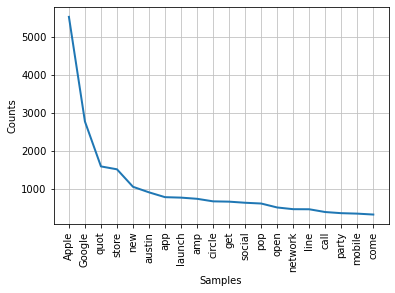

In [25]:

#Plot the 10 most common words
freq_dist.plot(20)
plt.show();

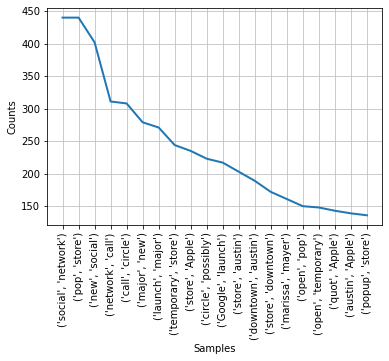

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [26]:
bigrams = nltk.bigrams(all_words)
tokenized_bigrams = nltk.FreqDist(bigrams)
tokenized_bigrams.most_common(20)
tokenized_bigrams.plot(20)

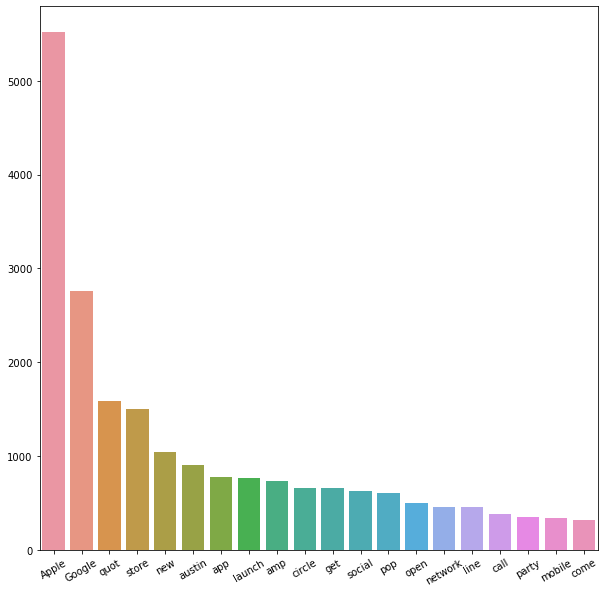

In [27]:
# Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = FreqDist(all_words).most_common(20)

# Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

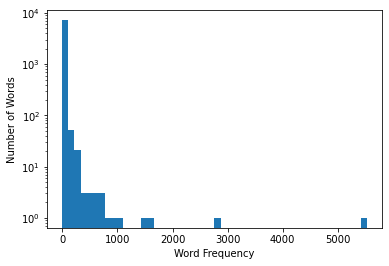

In [28]:
# Vectorize the text
vectorizer = CountVectorizer()
corpse = ()
X = vectorizer.fit_transform(data['text_with_product'])

# Sum the word frequencies
word_freq = X.sum(axis=0)

# Convert to a numpy array and flatten
word_freq = word_freq.A1

# Plot the distribution
plt.hist(word_freq, bins=50, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show();

In [29]:
##Convert word list to a single string
#words_string = " ".join(all_words)

##generating the wordcloud
#wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(words_string)

##plot the wordcloud
#plt.figure(figsize = (20, 10))
#plt.imshow(wordcloud)

##to remove the axis value
#plt.axis("off")
#plt.show();

#plt.savefig("cloudword.png")

# Train test split and evaluation metrics

In [30]:
# Assign the concatenated text to X
X = data['text_with_product']

# Assign the target labels to y
y = data['sentiment']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [32]:
#df to save results
results = pd.DataFrame(columns=["model","vectorizer", "val_score", "train_acc", "test_acc","train_recall", "test_recall", 
                                "train_precision", "test_precision","train_f1_score","test_f1_score","train_f1_score",
                                "train_logloss","test_logloss",'info'])

In [33]:
class EvaluationMetrics:
                           
    def __init__(self, pipe, X_train, X_test, y_train, y_test):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test= X_test
        self.y_train = y_train
        self.y_test = y_test

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted')}

        
        y_test_pred = self.pipe.predict(X_test)
        test_results_dict = {'accuracy': accuracy_score(y_test, y_test_pred),
                         'recall': recall_score(y_test, y_test_pred, average='weighted'),
                         'precision': precision_score(y_test, y_test_pred, average='weighted'),
                         'f1_score': f1_score(y_test, y_test_pred, average='weighted')}

        return train_results_dict, test_results_dict
        
    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)
        
     # Plots roc curve for all classes 
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()
    # Plots confussion matrix
    def plot_confusion_matrix(self, y_train, y_train_pred):
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

# Dummy Model

In [34]:
dummy = Pipeline([
    ('vect', CountVectorizer(min_df=0.05, max_df=0.95)),
    ('dummy', DummyClassifier(random_state=42, ))
])

# Fit the pipeline to the training data
dummy.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('dummy', DummyClassifier(random_state=42))])

Training Set Metrics:
accuracy: 0.47053140096618357
recall: 0.47053140096618357
precision: 0.46865451426380683
f1_score: 0.4695748179744871

Test set results:
accuracy: 0.45678416224046353
recall: 0.45678416224046353
precision: 0.46149688738325606
f1_score: 0.4591062995405255

cv set results:
Mean Accuracy: 0.46022544283413847
Standard Deviation of Accuracy: 0.013516981495287166


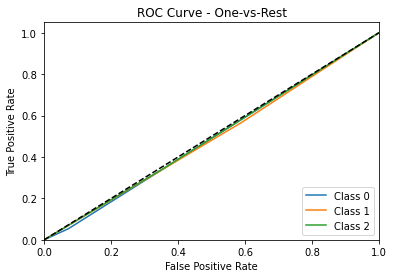

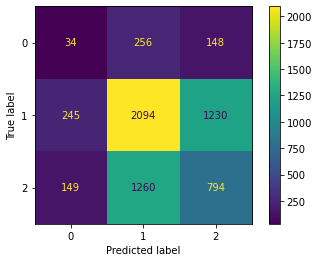

In [35]:
dummy_metrics = EvaluationMetrics(dummy, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = dummy_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = dummy_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

# Plot the ROC curve
dummy_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = dummy_metrics.pipe.predict(X_train)
dummy_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [36]:
results

,model,vectorizer,val_score,train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1_score,test_f1_score,train_f1_score,train_logloss,test_logloss,info


In [66]:
###NEEEEEEEED TO FIX THISSSSSSSSSSSS
# results = pd.DataFrame(columns=[
#     "model", "vectorizer", "val_score", "train_acc", "test_acc",
#     "train_recall", "test_recall", "train_precision", "test_precision",
#     "train_f1_score", "test_f1_score",
#     "train_logloss", "test_logloss", 'info'
# ])
# 
# # First model, baseline performance to record to our results table
# # This to used as a recorder for rest of models
# result = pd.DataFrame({
#             "model": [results],
#             "vectorizer": [vectorizer],
#             "val_score": [val_score],
#             "train_acc": [train_acc],
#             "test_acc": [test_acc],
#             "train_recall": [train_recall],
#             "test_recall": [test_recall],
#             "train_precision": [train_precision],
#             "test_precision": [test_precision],
#             "train_f1_score": [train_f1_score],
#             "test_f1_score": [test_f1_score],
#             "train_logloss": [train_logloss],
#             "test_logloss": [test_logloss],
#             'info': [info]
#         })
# 
# results = pd.concat([results, results_1], ignore_index=True)

# Logistic Regression using CountVectorizer

In [38]:
fsm = Pipeline([
    ('vect', CountVectorizer(min_df=0.05, max_df=0.95)),
    ('logreg', LogisticRegression(random_state=42, ))
])

# Fit the pipeline to the training data
fsm.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('logreg', LogisticRegression(random_state=42))])

Training Set Metrics:
accuracy: 0.5811594202898551
recall: 0.5811594202898551
precision: 0.5151416274363538
f1_score: 0.4882220671784914

Test set results:
accuracy: 0.5895702559150169
recall: 0.5895702559150169
precision: 0.5232866584016896
f1_score: 0.5015414730956146

cv set results:
Mean Accuracy: 0.5792270531400966
Standard Deviation of Accuracy: 0.005030756635044566


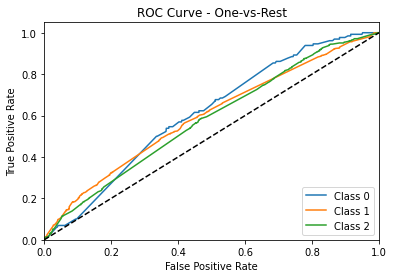

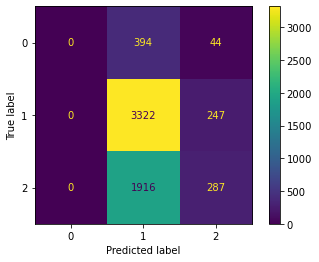

In [39]:
fsm_metrics = EvaluationMetrics(fsm, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = fsm_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = fsm_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
fsm_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = fsm_metrics.pipe.predict(X_train)
fsm_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [40]:
results

,model,vectorizer,val_score,train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1_score,test_f1_score,train_logloss,test_logloss,info
0,DummyRegressor,CountVectorizer,0.574,0.33,0.33,None,None,None,None,None,None,None,16.42,baseline


# Logistic regression with Tf-idf vectorizer

In [41]:
lrpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('logreg', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training data
lrpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('logreg', LogisticRegression(random_state=42))])

Training Set Metrics:
accuracy: 0.856682769726248
recall: 0.856682769726248
precision: 0.8718864098976451
f1_score: 0.8374482055192215

Test set results:
accuracy: 0.6880733944954128
recall: 0.6880733944954128
precision: 0.6913703008752123
f1_score: 0.6604043695789253

cv set results:
Mean Accuracy: 0.6647342995169081
Standard Deviation of Accuracy: 0.006533160314042118


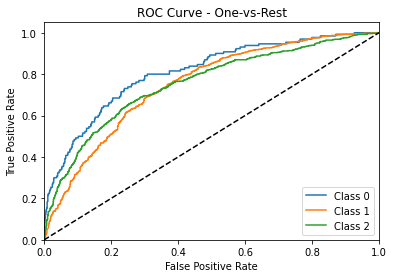

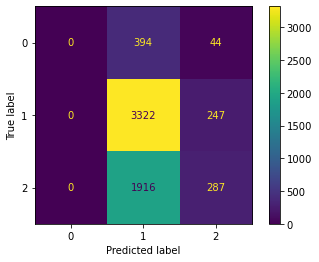

In [42]:
lrpipe_metrics = EvaluationMetrics(lrpipe, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = lrpipe_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = lrpipe_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
lrpipe_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_t_pred = lrpipe_metrics.pipe.predict(X_train)
lrpipe_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [43]:
#results

# Synthethic Balancing with Tf-idf and Logistic Regression

In [44]:
from imblearn.pipeline import make_pipeline

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler()

# Define the pipeline
lrpipe_os = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    oversampler,
    LogisticRegression(random_state=42)
)

# Fit the pipeline to the training data
lrpipe_os.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('randomoversampler', RandomOverSampler()),
                ('logisticregression', LogisticRegression(random_state=42))])

Training Set Metrics:
accuracy: 0.9157809983896941
recall: 0.9157809983896941
precision: 0.9171961943987414
f1_score: 0.9159131170082008

Test set results:
accuracy: 0.6591018831482376
recall: 0.6591018831482376
precision: 0.6617877911536665
f1_score: 0.6603663324730733

cv set results:
Mean Accuracy: 0.6516908212560386
Standard Deviation of Accuracy: 0.009696662941916012


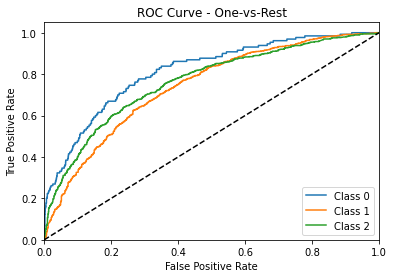

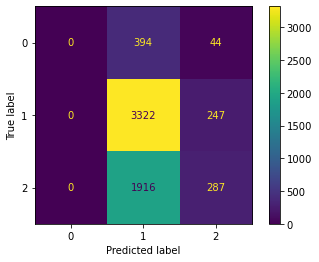

In [45]:
lrpipe_os_metrics = EvaluationMetrics(lrpipe_os, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = lrpipe_os_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = lrpipe_os_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
lrpipe_os_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_t_pred = lrpipe_os_metrics.pipe.predict(X_train)
lrpipe_os_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [46]:
#results

In [47]:
from imblearn.over_sampling import SMOTE


# Create an instance of SMOTE
smote = SMOTE()

# Define the pipeline
lrpipe_sm = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    smote,
    LogisticRegression(random_state=42)
)

# Fit the pipeline to the training data
lrpipe_sm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression(random_state=42))])

Training Set Metrics:
accuracy: 0.9135265700483092
recall: 0.9135265700483092
precision: 0.9151351029593967
f1_score: 0.9137084068891778

Test set results:
accuracy: 0.6629647513278609
recall: 0.6629647513278609
precision: 0.665923672535368
f1_score: 0.6643605759814698

cv set results:
Mean Accuracy: 0.6526570048309178
Standard Deviation of Accuracy: 0.012500372750451103


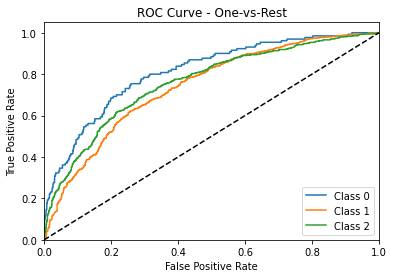

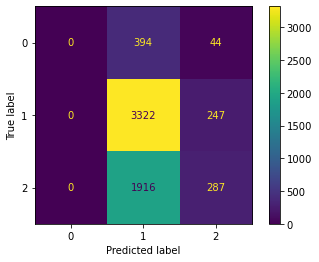

In [48]:
lrpipe_sm_metrics = EvaluationMetrics(lrpipe_sm, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = lrpipe_sm_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = lrpipe_sm_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
lrpipe_sm_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_t_pred = lrpipe_sm_metrics.pipe.predict(X_train)
lrpipe_sm_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [49]:
#results

# MultinomialNB

In [50]:
mnbpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('mnb', MultinomialNB())
])

# Fit the pipeline to the training data
mnbpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('mnb', MultinomialNB())])

Training Set Metrics:
accuracy: 0.8130434782608695
recall: 0.8130434782608695
precision: 0.8413620245028408
f1_score: 0.7831684589754618

Test set results:
accuracy: 0.644133268952197
recall: 0.644133268952197
precision: 0.6802240666097273
f1_score: 0.5803848748139572

cv set results:
Mean Accuracy: 0.6325281803542673
Standard Deviation of Accuracy: 0.005306685041315298


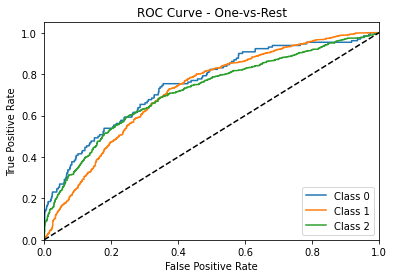

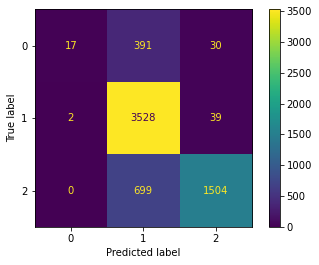

In [51]:
mnbpipe_metrics = EvaluationMetrics(mnbpipe, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = mnbpipe_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = mnbpipe_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
mnbpipe_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = mnbpipe_metrics.pipe.predict(X_train)
mnbpipe_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [52]:
# MultinomialNB with Countvector

In [53]:
mnbpipe_cv = Pipeline([
    ('vect', CountVectorizer()),
    ('mnb', MultinomialNB())
])

# Fit the pipeline to the training data
mnbpipe_cv.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('mnb', MultinomialNB())])

Training Set Metrics:
accuracy: 0.8074074074074075
recall: 0.8074074074074075
precision: 0.8085694541251199
f1_score: 0.8022459700434748

Test set results:
accuracy: 0.6581361661033317
recall: 0.6581361661033317
precision: 0.6469249434942412
f1_score: 0.6448938328160905

cv set results:
Mean Accuracy: 0.6529790660225443
Standard Deviation of Accuracy: 0.006174006284277262


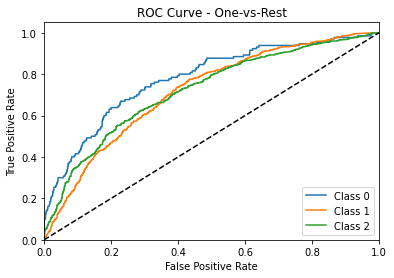

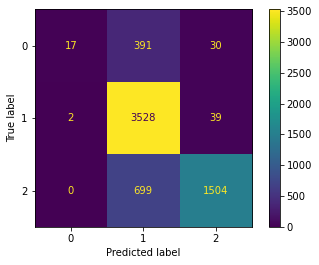

In [54]:
mnbpipe_cv_metrics = EvaluationMetrics(mnbpipe_cv, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = mnbpipe_cv_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = mnbpipe_cv_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
mnbpipe_cv_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = mnbpipe_metrics.pipe.predict(X_train)
mnbpipe_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Smote Balanced MultinomialNB

In [56]:
# Define the pipeline
mnbpipe_sm = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    smote,
    MultinomialNB()
)

# Fit the pipeline to the training data
mnbpipe_sm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()), ('multinomialnb', MultinomialNB())])

Training Set Metrics:
accuracy: 0.885024154589372
recall: 0.885024154589372
precision: 0.8946780545118983
f1_score: 0.886713405496118

Test set results:
accuracy: 0.607436021245775
recall: 0.607436021245775
precision: 0.6486023536941234
f1_score: 0.6212862109565526

cv set results:
Mean Accuracy: 0.601610305958132
Standard Deviation of Accuracy: 0.007895427164013695


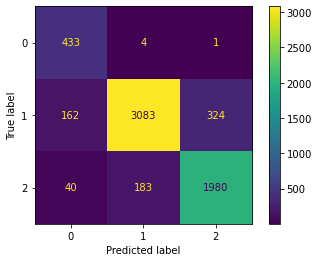

In [57]:
mnbpipe_sm_metrics = EvaluationMetrics(mnbpipe_sm, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = mnbpipe_sm_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = mnbpipe_sm_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
#eval_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = mnbpipe_sm_metrics.pipe.predict(X_train)
mnbpipe_sm_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Random Forest
>- Initial try with no parameters was overfit with training at 95% and test accuracy at 0.66

In [84]:
rfpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('rf', RandomForestClassifier())
])

# Fit the pipeline to the training data
rfpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())])

Training Set Metrics:
accuracy: 0.9537842190016103
recall: 0.9537842190016103
precision: 0.9541025681267531
f1_score: 0.9536314163684018

Test set results:
accuracy: 0.6552390149686141
recall: 0.6552390149686141
precision: 0.6429414485241582
f1_score: 0.6353239041849241

cv set results:
Mean Accuracy: 0.6655394524959742
Standard Deviation of Accuracy: 0.011256027128696501


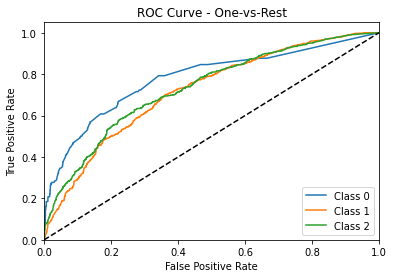

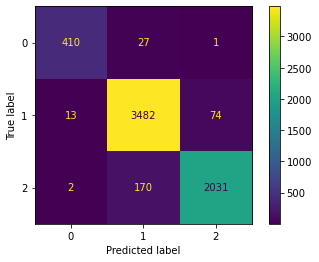

In [85]:
rfpipe_metrics = EvaluationMetrics(rfpipe, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = rfpipe_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = rfpipe_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
rfpipe_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = rfpipe_metrics.pipe.predict(X_train)
eval_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Bagging

In [54]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Define the individual classifiers
lg = LogisticRegression(max_iter=1000, random_state=42)
mnb = MultinomialNB()
rf = RandomForestClassifier()

# Define the voting classifier
vc = VotingClassifier(
    estimators=[
        ('logreg', lg),
        ('mnb', mnb),
        ('rf', rf)
    ],
    voting='soft'
)

# Create the pipeline
vc_pipeline = make_pipeline(vectorizer, vc)

# Fit the pipeline to the training data
vc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('votingclassifier',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42)),
                                              ('mnb', MultinomialNB()),
                                              ('rf', RandomForestClassifier())],
                                  voting='soft'))])

Training Set Metrics:
accuracy: 0.8916264090177134
recall: 0.8916264090177134
precision: 0.9031568859116065
f1_score: 0.8820823763302807

Test set results:
accuracy: 0.6711733462095606
recall: 0.6711733462095606
precision: 0.6768650803242392
f1_score: 0.6375030013893609

cv set results:
Mean Accuracy: 0.6563607085346217
Standard Deviation of Accuracy: 0.005227917256279549


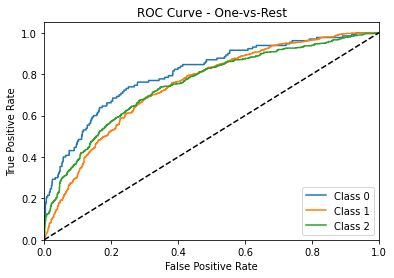

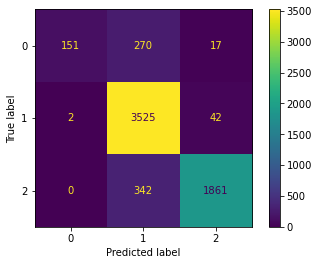

In [56]:
vc_metrics = EvaluationMetrics(vc_pipeline, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = vc_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = vc_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
vc_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = vc_metrics.pipe.predict(X_train)
vc_metrics.plot_confusion_matrix(y_train, y_train_pred)

# XGBoost

In [257]:
#!pip install xgboost

In [86]:
from xgboost import XGBClassifier

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Define the individual classifiers
lg = LogisticRegression(max_iter=1000, random_state=42)
mnb = MultinomialNB()
xgb = XGBClassifier(
    estimators=[
        ('logreg', lg),
        ('mnb', mnb),
        ('rf', rf)
    ],
    voting='soft'
)

# Create the pipeline with XGBoost instead of VotingClassifier
xgb_pipeline = make_pipeline(vectorizer, xgb)

# Fit the pipeline to the training data
xgb_pipeline.fit(X_train, y_train)

[10:10:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { estimators, voting } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1,
                               estimators=[('logreg',
                                            LogisticRegression(max_iter=1000,
                                                               random_state=42)),
                                           ('mnb', MultinomialNB()),
                                           ('rf', RandomForestClassifier())],
                               gamma=0, gpu_id=-1, importance...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

In [87]:
xgb_metrics = EvaluationMetrics(xgb_pipeline, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = xgb_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = xgb_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Training Set Metrics:
accuracy: 0.8199677938808374
recall: 0.8199677938808374
precision: 0.8395413342106832
f1_score: 0.8105322717008628

Test set results:
accuracy: 0.6711733462095606
recall: 0.6711733462095606
precision: 0.6646636567878951
f1_score: 0.6405608702970154

cv set results:
[10:10:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { estimators, voting } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:10:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { estimators, voting } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but sl

# Randomized Search

In [64]:
#from scipy.stats import uniform
# from numpy.random import randint

# parameters = { 
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'vect__max_df': uniform(0.5, 0.5),
#     'vect__min_df': uniform(0.01, 0.09),
#     'vect__max_features': [500, 1000, 1500, 2000],
#     'vect__analyzer': ['word', 'char', 'char_wb'],
#     'logreg__C': uniform(0.001, 1000),
#     'logreg__max_iter': randint(250, 1501),
#     'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'],
#     'logreg__penalty': ['l1', 'l2'],
#     'logreg__class_weight': ['balanced'],
#     'logreg__multi_class': [None, 'ovr', 'multinomial']
# }

In [65]:
# Perform random search
# random_search = RandomizedSearchCV(lrpipe, parameters, n_iter=10, cv=5, scoring='accuracy', random_state=42)
# random_search.fit(X_train, y_train)

In [77]:
# Print the best parameters and score
# print("Best Parameters: ", random_search.best_params_)
# print("Best Score: ", random_search.best_score_)

In [88]:
# Specify hyperparameters and their distributions
parameters = { 
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [0.01, 0.05, 0.1],
    'vect__max_features': [500, 1000, 1500, 2000],
    'vect__analyzer': ['word', 'char', 'char_wb'],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logreg__max_iter': [250, 750, 1000, 1500],
    'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__class_weight': ['balanced'],
    'logreg__multi_class': [None, 'ovr', 'multinomial']
}

In [ ]:
# Instantiate GridSearchCV object using the lrpipe pipeline
grid_search_lr = GridSearchCV(lrpipe, parameters, cv=5, n_jobs=-1)

# # Fit on data

grid_search_lr.fit(X_train, y_train)

In [80]:
eval_metrics = EvaluationMetrics(random_search, X_train, X_test, y_train, y_test)

# # Print the evaluation metrics
train_results, test_results = eval_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = eval_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# # Plot the ROC curve
eval_metrics.plot_roc_curve_ovr()

# #Plot MAtrix Confusion
y_train_pred = eval_metrics.pipe.predict(X_train)
eval_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [266]:
#filename = 'gridsearch_model.sav'
#joblib.dump(gridsearch_search, filename)

In [267]:
# Gridsearch/randomsearch MNB (Deniz)

In [81]:
parameters_mnb = { 
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [0.01, 0.05, 0.1],
    'vect__max_features': [500, 1000, 1500, 2000],
    'vect__analyzer': ['word', 'char', 'char_wb'],
    'mnb__alpha': [0.1, 0.5, 1.0, 2.0],
    'mnb__fit_prior': [True, False]
}

In [82]:
# Instantiate GridSearchCV object using the lrpipe pipeline
grid_search_mnb = GridSearchCV(mnbpipe_cv, parameters_mnb, cv=5, n_jobs=-1)

# # Fit on data
grid_search_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'mnb__alpha': [0.1, 0.5, 1.0, 2.0],
                         'mnb__fit_prior': [True, False],
                         'vect__analyzer': ['word', 'char', 'char_wb'],
                         'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__max_features': [500, 1000, 1500, 2000],
                         'vect__min_df': [0.01, 0.05, 0.1],
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [270]:
# Gridsearch/randomsearch Randomforest

# Embedding

In [271]:
#How to pull a specific predictor out

In [83]:
import tensorflow as tf
from sklearn.linear_model import LogisticRegression

# # Define the vocabulary size and embedding dimensions
vocab_size = 10000
embedding_dim = 200

# # Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)

# # Define your logistic regression model
logreg_model = LogisticRegression()

# # Train your embedding layer on your text data
# # (Assuming you have preprocessed and tokenized your text data)
X_train_embedded = embedding_layer(X_train)

# # Flatten the embedded data if needed
X_train_embedded_flat = tf.keras.layers.Flatten()(X_train_embedded)

# # Fit the logistic regression model on the embedded data
logreg_model.fit(X_train_embedded_flat, y_train)

# # Apply the same embedding layer and logistic regression model on test data
X_test_embedded = embedding_layer(X_test)
X_test_embedded_flat = tf.keras.layers.Flatten()(X_test_embedded)
y_pred = logreg_model.predict(X_test_embedded_flat)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

In [273]:
# from gensim.models import Word2Vec

# # Preprocess and tokenize your text data
# # Assuming you have a list of sentences called 'sentences'

# # Train Word2Vec model
# model = Word2Vec(data['text_with_product'], size=100, window=5, min_count=20, workers=4)

# # Get the vocabulary size and embedding dimensions
# vocab_size = len(model.wv.vocab)
# embedding_dim = model.vector_size

# # Create an embedding matrix
# embedding_matrix = model.wv.vectors

# # Define your logistic regression model
# logreg_model = LogisticRegression()

# # Train your logistic regression model on the embedded data
# logreg_model.fit(embedding_matrix, y_train)

# # Apply the same embedding and logistic regression model on test data
# X_test_embedded = [model.wv[word] for word in X_test]
# y_pred = logreg_model.predict(X_test_embedded)